<style>
body {
    font-size: 20pt !important;
}

.rendered_html {
    font-size: 20pt !important;
}

.CodeMirror pre {
    font-size: 20pt !important;
}

.output pre {
    font-size: 20pt !important;
}
</style>


<h2 style="font-size:24pt"> Proyecto DESI</h2>

<h2 style="font-size:24pt"> Julio 3, 2025</h2>

<p style="font-size:16pt">
Conversión de datos desde RAC, DEC y z a coordenadas esféricas y finalmente a coordenadas x,y y z.
</p>


## Data

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.cosmology import Planck18
from astropy.io import ascii
import random

In [5]:
# original files are found here https://data.desi.lbl.gov/public/edr/vac/edr/lss/v2.0/LSScats/clustering/
data_n = Table.read("https://data.desi.lbl.gov/public/edr/vac/edr/lss/v2.0/LSScats/clustering/LRG_N_clustering.dat.fits")
data_s = Table.read("https://data.desi.lbl.gov/public/edr/vac/edr/lss/v2.0/LSScats/clustering/LRG_S_clustering.dat.fits")

In [100]:
list_rand = list(range(18))
rand_tables_n = {}

for i in list_rand:
    url = f"https://data.desi.lbl.gov/public/edr/vac/edr/lss/v2.0/LSScats/clustering/LRG_N_{i}_clustering.ran.fits"
    rand_tables_n[f"rand_{i}_n"] = Table.read(url)

In [101]:
rand_tables_s = {}

for i in list_rand:
    url = f"https://data.desi.lbl.gov/public/edr/vac/edr/lss/v2.0/LSScats/clustering/LRG_S_{i}_clustering.ran.fits"
    rand_tables_s[f"rand_{i}_n"] = Table.read(url)

<p style="font-size:16pt">
$$\theta = 90 - \delta$$
$$\varphi = -\alpha$$
$$ z = r [Mpc] $$

In [20]:
def esfericas(data):
    data['theta']= 90 - data['DEC']
    data['phi'] = - data['RA']
    data['r'] = Planck18.comoving_distance(data['Z'])

In [21]:
esfericas(data_n)
esfericas(data_s)

<p style="font-size:16pt">
\begin{align*}
x &= r \sin\theta \cos\varphi \\
y &= r \sin\theta \sin\varphi \\
z &= r \cos\theta
\end{align*}


In [22]:
def cartesianas(data):
    data['x'] = data['r']*np.sin(data['theta'])*np.cos(data['phi'])
    data['y'] = data['r']*np.sin(data['theta'])*np.sin(data['phi'])
    data['z'] = data['r']*np.cos(data['theta'])

In [23]:
cartesianas(data_n)
cartesianas(data_s)

In [125]:
def save_file(number_rosette,data):
    
    #Choose random table
    clave_aleatoria = random.choice(list(rand_tables_n.keys()))
    rand_table = rand_tables_n[clave_aleatoria]

    #Filter of the rosette
    rosette = data[data['ROSETTE_NUMBER']==number_rosette]

    #Choose random index of the random table according to the len of rosette table
    len_rosette = len(rosette)
    idx_random = np.random.choice(len(rand_table), size=len_rosette, replace=False)
    rand_subset = rand_table[idx_random]

    #Add columns of the othe coordinates
    esfericas(rand_subset)
    cartesianas(rand_subset)

    #Filenames
    filename_data = f'data_rosette/LRG_{number_rosette}_clustering_data.ecsv'
    filename_rand = f'data_rosette/LRG_{number_rosette}_clustering_rand.ecsv'

    #Write
    ascii.write(rosette, filename_data, format='ecsv', overwrite=True)
    ascii.write(rand_subset, filename_rand, format='ecsv', overwrite=True)

In [126]:
#Save files north
for i in set(data_n['ROSETTE_NUMBER']):
    save_file(i,data_n)

In [127]:
#Save files south
for i in set(data_s['ROSETTE_NUMBER']):
    save_file(i,data_s)

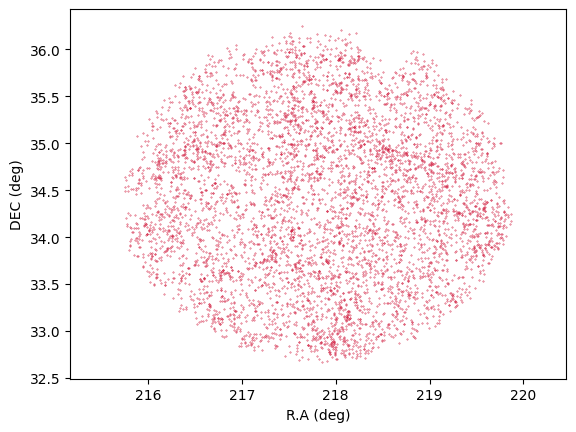

In [22]:
rosette_all(conditions_n[2],data_n)

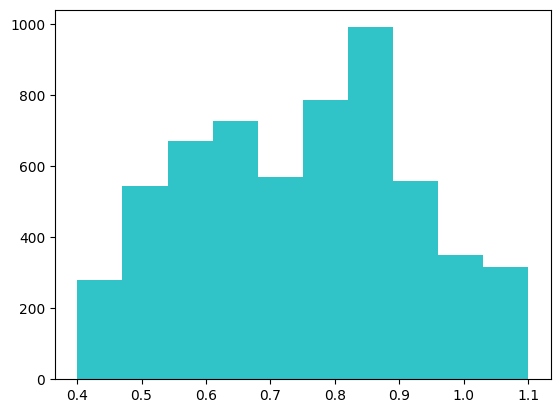

In [23]:
max_value_7_n = max_value(conditions_n[2],data_n)

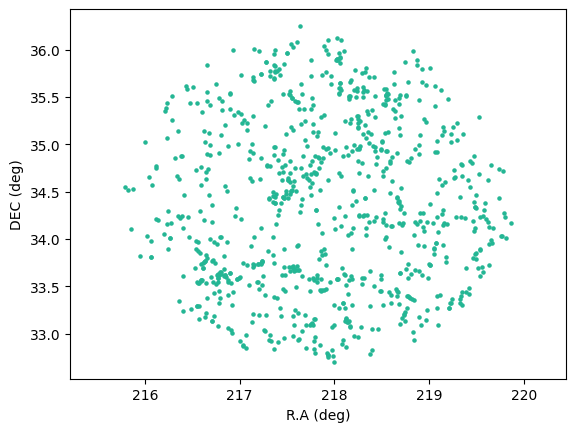

In [24]:
rosette(conditions_n[2],data_n,max_value_7_n[0],max_value_7_n[2])

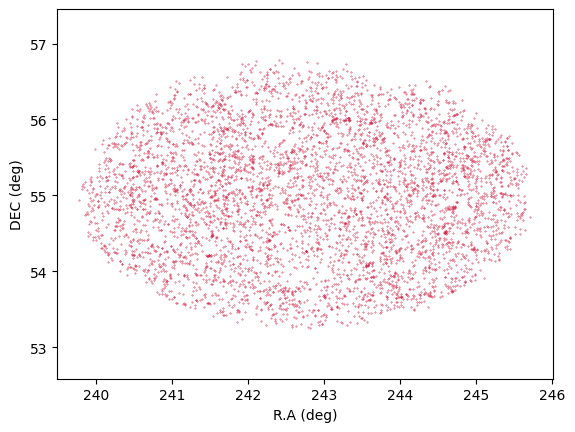

In [25]:
rosette_all(conditions_n[3],data_n)

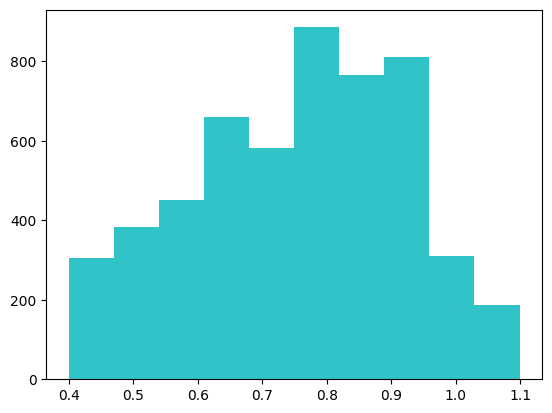

In [26]:
max_value_11_n = max_value(conditions_n[3],data_n)

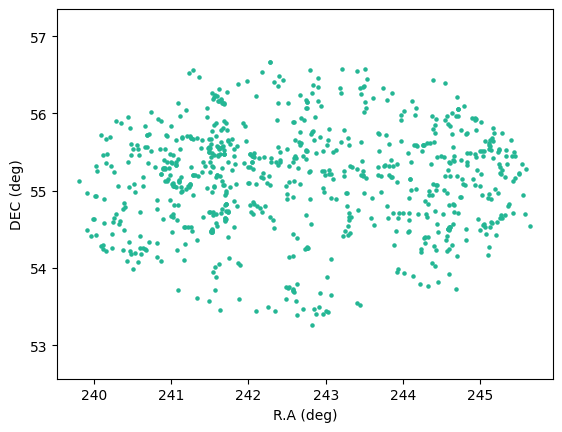

In [27]:
rosette(conditions_n[3],data_n,max_value_11_n[0],max_value_11_n[2])

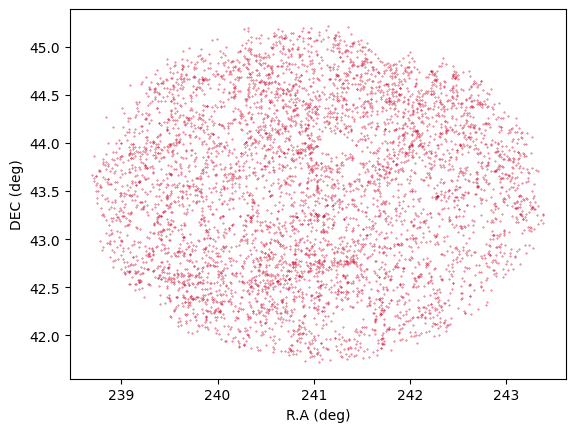

In [28]:
rosette_all(conditions_n[4],data_n)

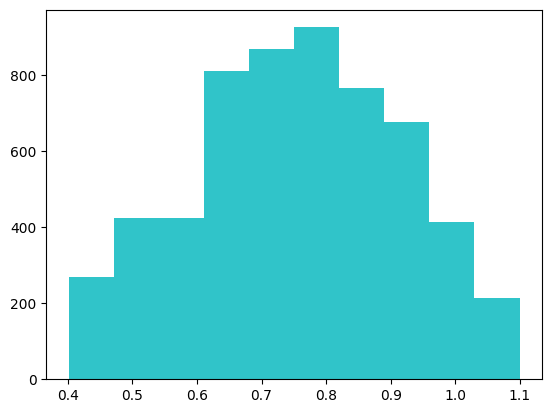

In [29]:
max_value_12_n = max_value(conditions_n[4],data_n)

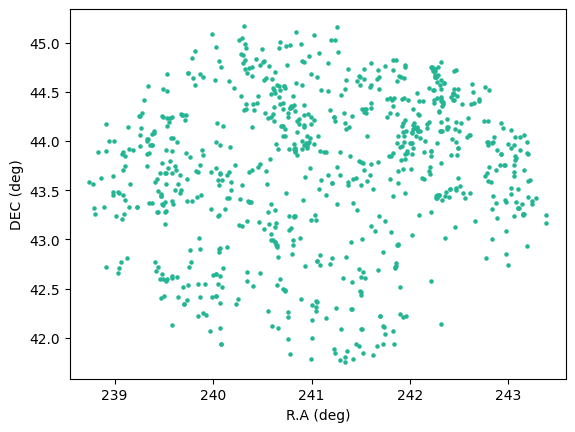

In [30]:
rosette(conditions_n[4],data_n,max_value_12_n[0],max_value_12_n[2])

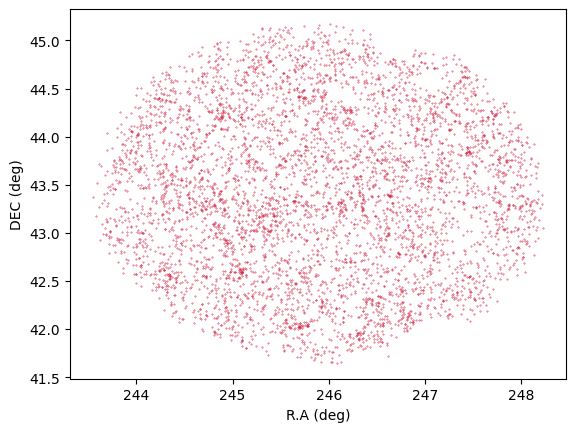

In [31]:
rosette_all(conditions_n[5],data_n)

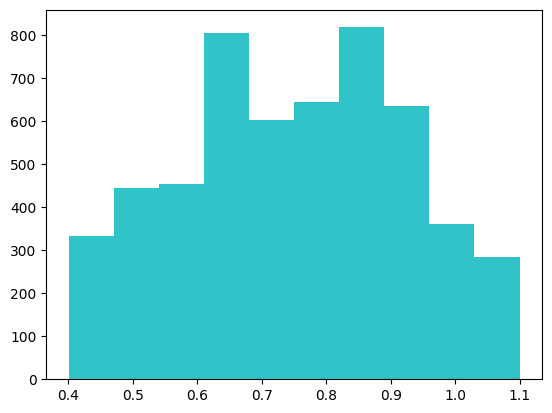

In [32]:
max_value_13_n = max_value(conditions_n[5],data_n)

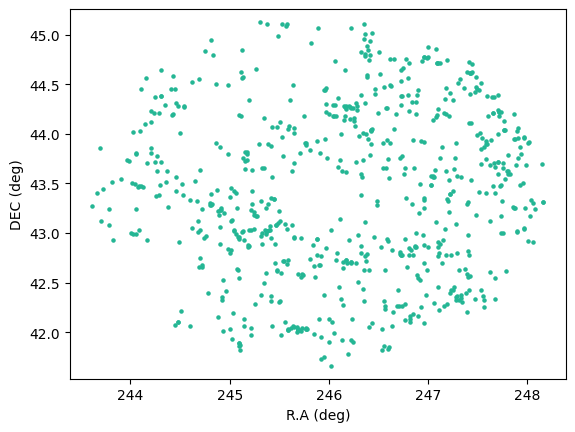

In [33]:
rosette(conditions_n[5],data_n,max_value_13_n[0],max_value_13_n[2])

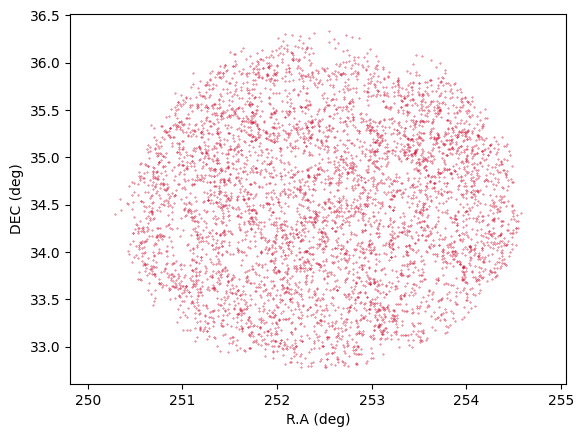

In [34]:
rosette_all(conditions_n[6],data_n)

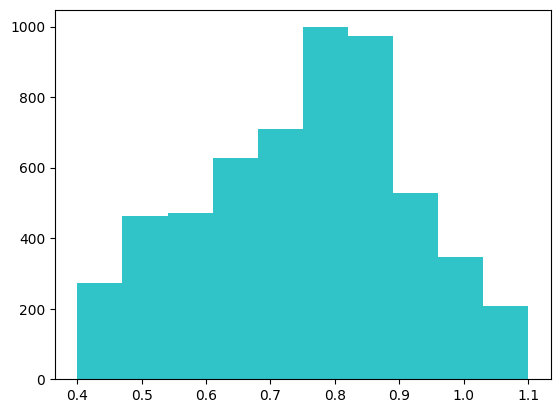

In [35]:
max_value_14_n = max_value(conditions_n[6],data_n)

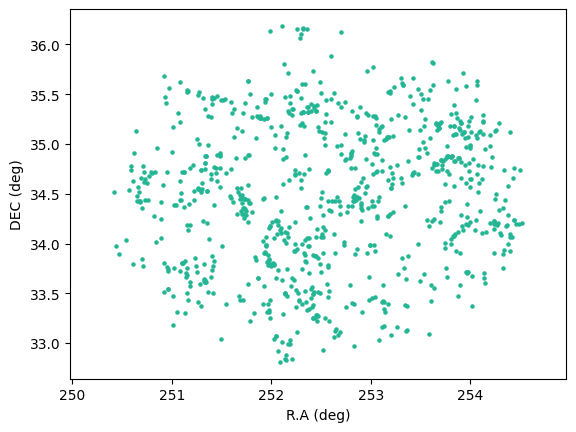

In [36]:
rosette(conditions_n[6],data_n,max_value_14_n[0],max_value_14_n[2])

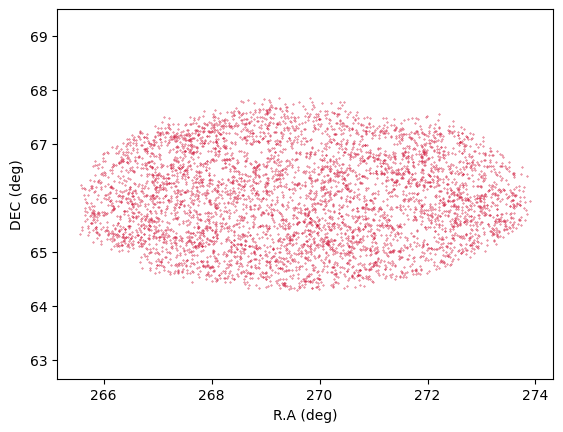

In [37]:
rosette_all(conditions_n[7],data_n)

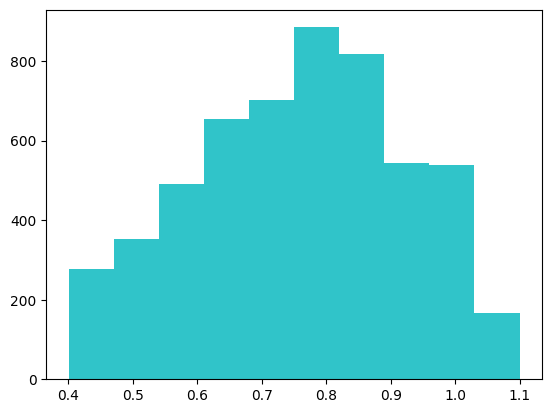

In [38]:
max_value_15_n = max_value(conditions_n[7],data_n)

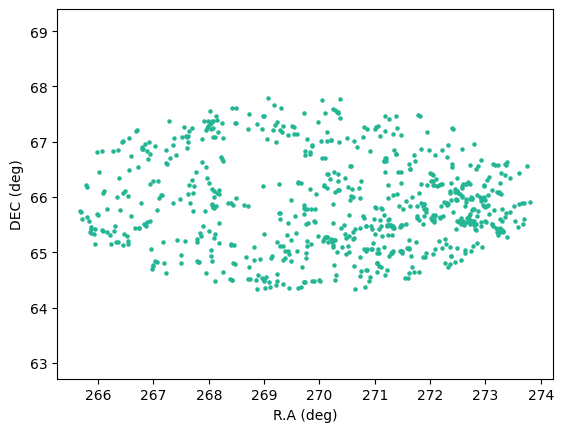

In [39]:
rosette(conditions_n[7],data_n,max_value_15_n[0],max_value_15_n[2])

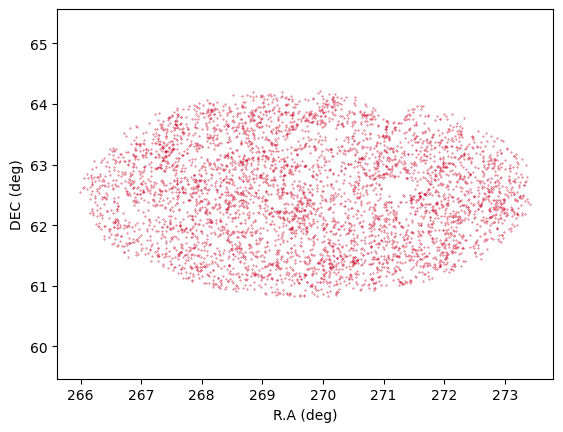

In [40]:
rosette_all(conditions_n[8],data_n)

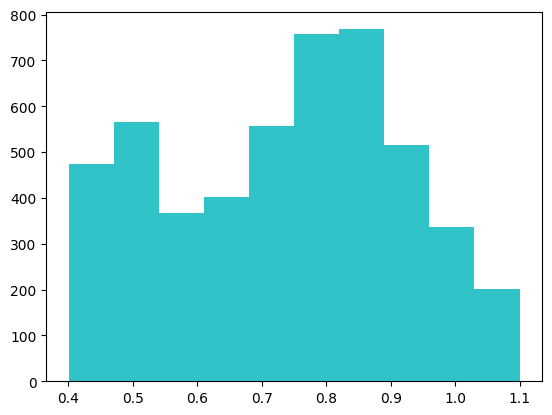

In [41]:
max_value_18_n = max_value(conditions_n[8],data_n)

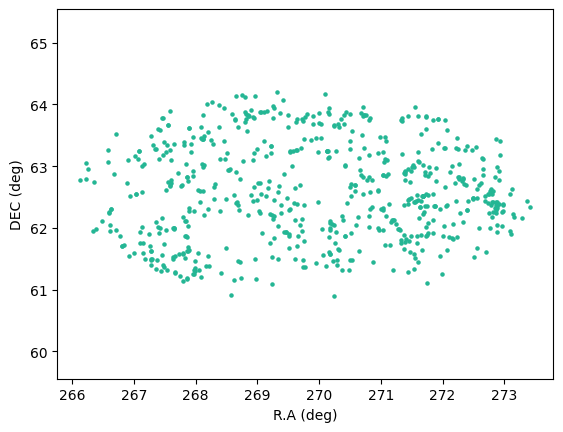

In [42]:
rosette(conditions_n[8],data_n,max_value_18_n[0],max_value_18_n[2])

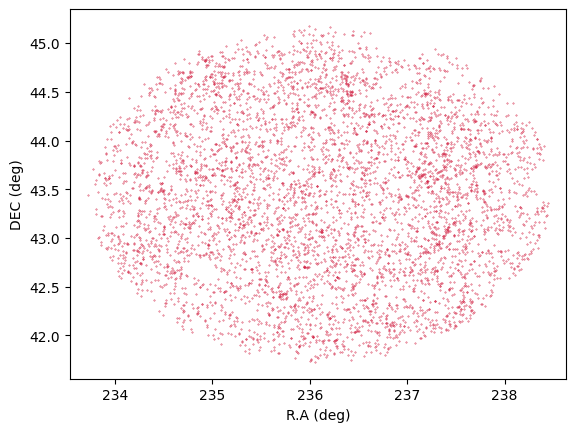

In [43]:
rosette_all(conditions_n[9],data_n)

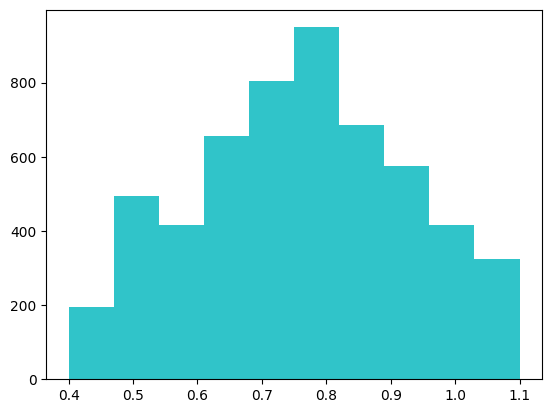

In [44]:
max_value_19_n = max_value(conditions_n[9],data_n)

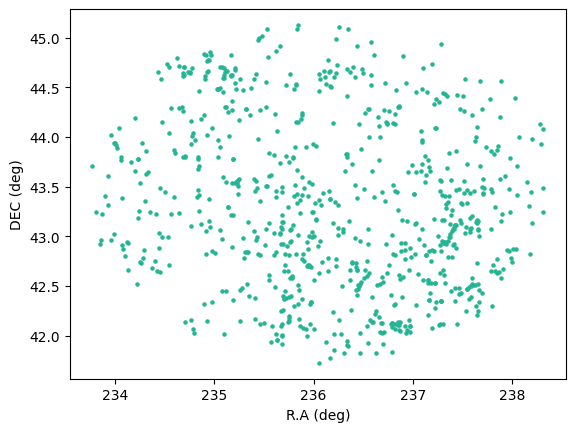

In [45]:
rosette(conditions_n[9],data_n,max_value_19_n[0],max_value_19_n[2])

In [46]:
set(data_s['ROSETTE_NUMBER'])

{0, 1, 2, 4, 5, 8, 9, 10, 16, 17}

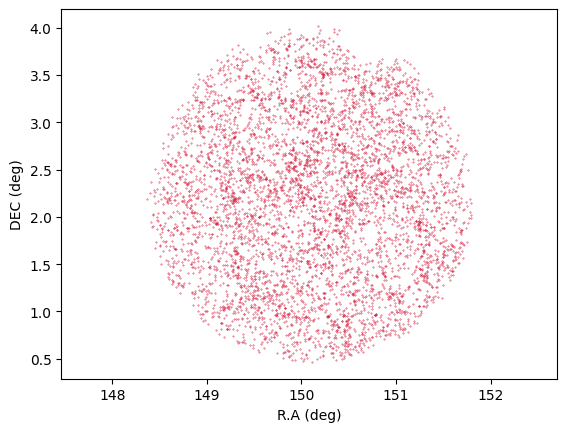

In [47]:
rosette_all(conditions_s[0],data_s)

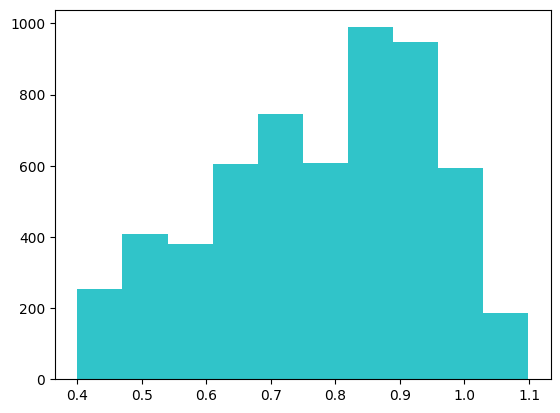

In [48]:
max_value_0_s = max_value(conditions_s[0],data_s)

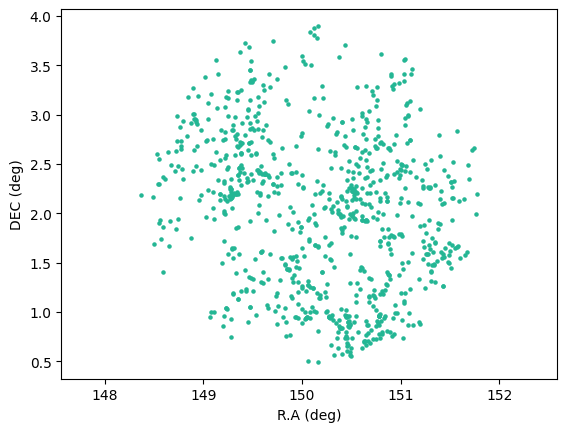

In [49]:
rosette(conditions_s[0],data_s,max_value_0_s[0],max_value_0_s[2])

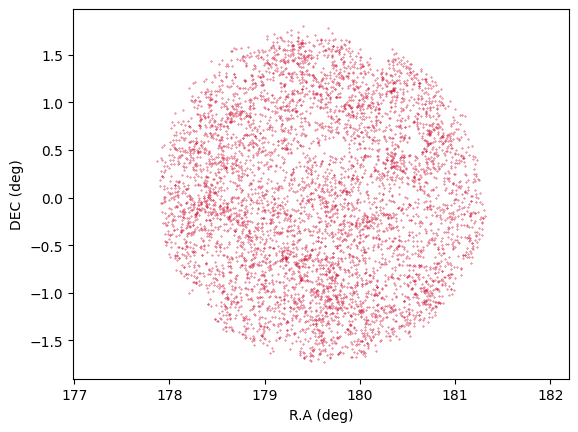

In [50]:
rosette_all(conditions_s[1],data_s)

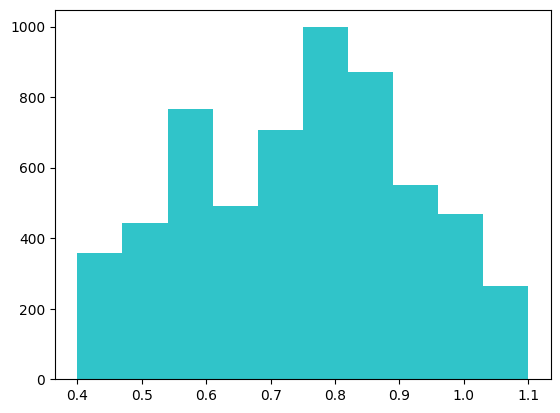

In [51]:
max_value_1_s = max_value(conditions_s[1],data_s)

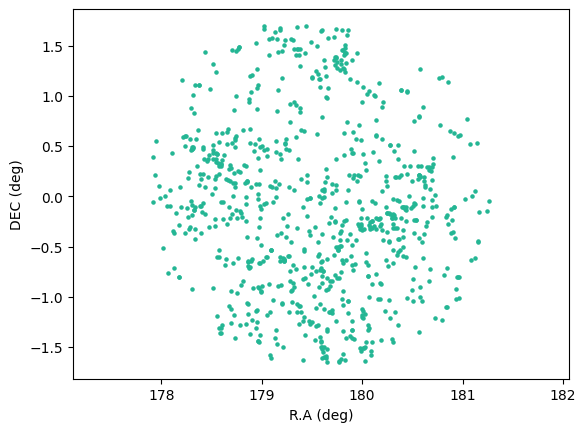

In [52]:
rosette(conditions_s[1],data_s,max_value_1_s[0],max_value_1_s[2])

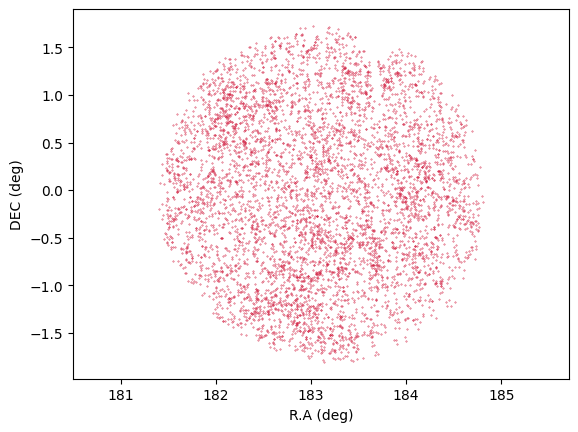

In [53]:
rosette_all(conditions_s[2],data_s)

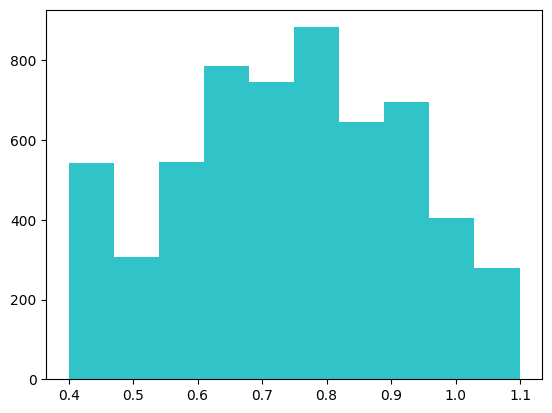

In [54]:
max_value_2_s = max_value(conditions_s[2],data_s)

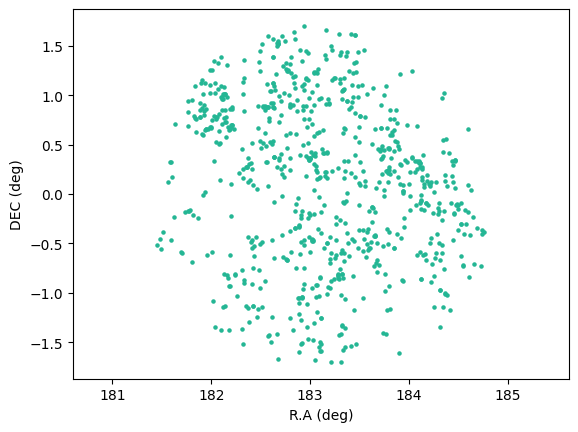

In [55]:
rosette(conditions_s[2],data_s,max_value_2_s[0],max_value_2_s[2])

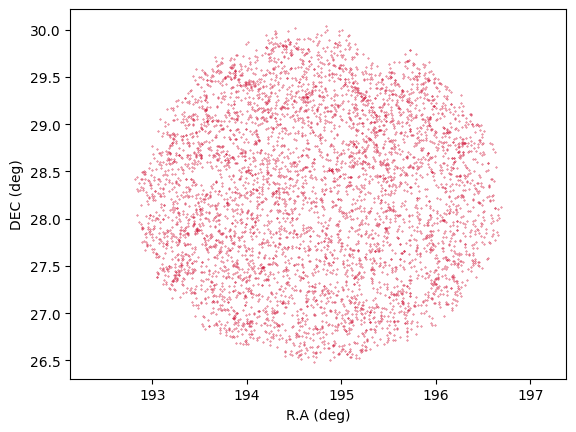

In [56]:
rosette_all(conditions_s[3],data_s)

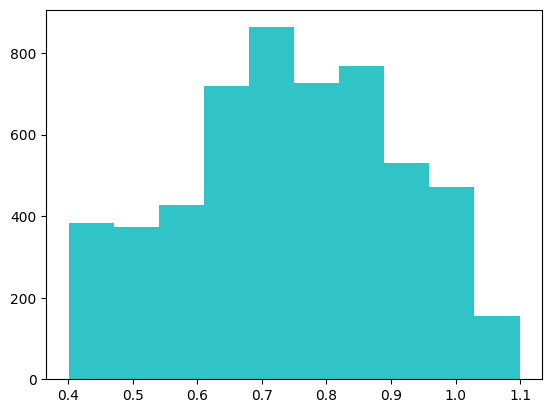

In [57]:
max_value_4_s = max_value(conditions_s[3],data_s)

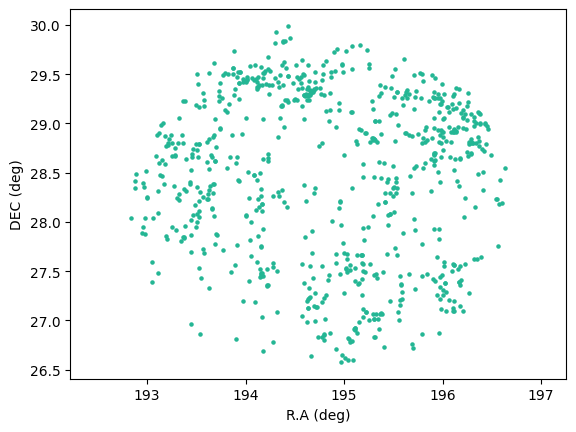

In [58]:
rosette(conditions_s[3],data_s,max_value_4_s[0],max_value_4_s[2])

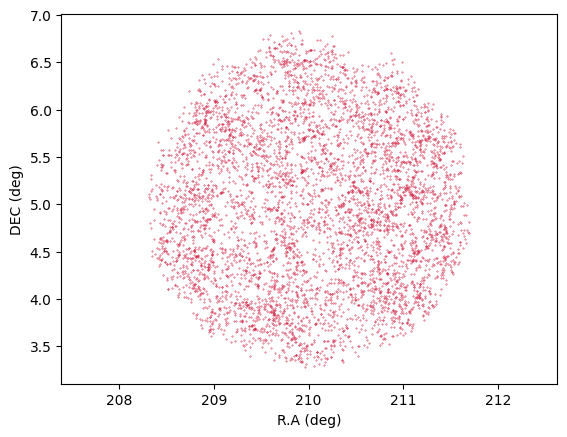

In [59]:
rosette_all(conditions_s[4],data_s)

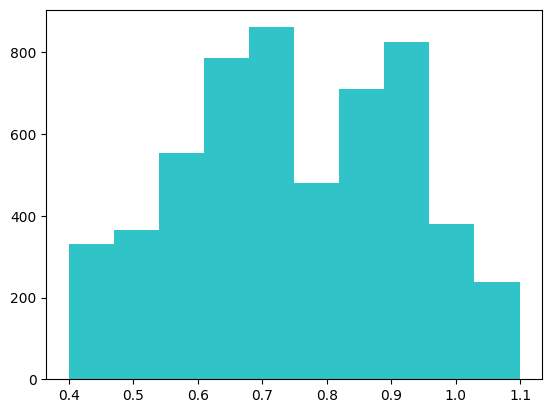

In [60]:
max_value_5_s = max_value(conditions_s[4],data_s)

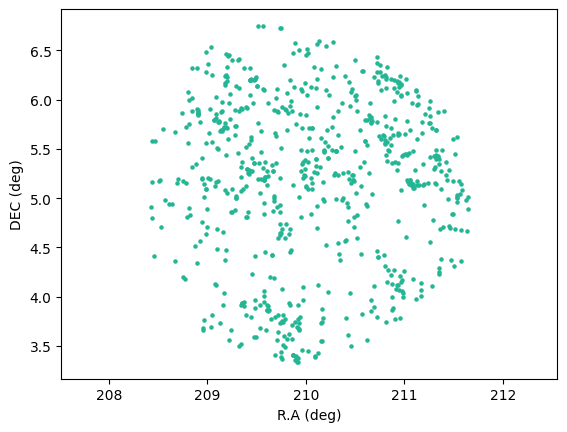

In [61]:
rosette(conditions_s[4],data_s,max_value_5_s[0],max_value_5_s[2])

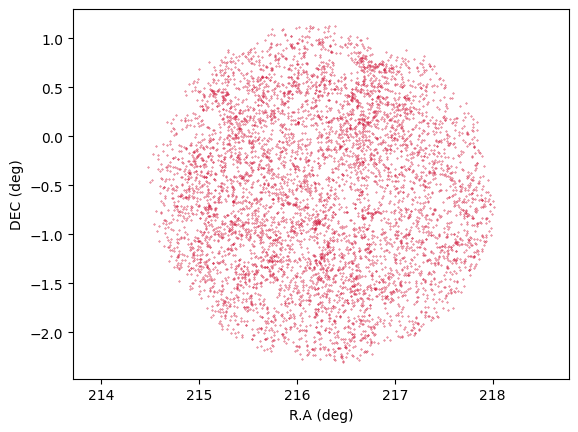

In [62]:
rosette_all(conditions_s[5],data_s)

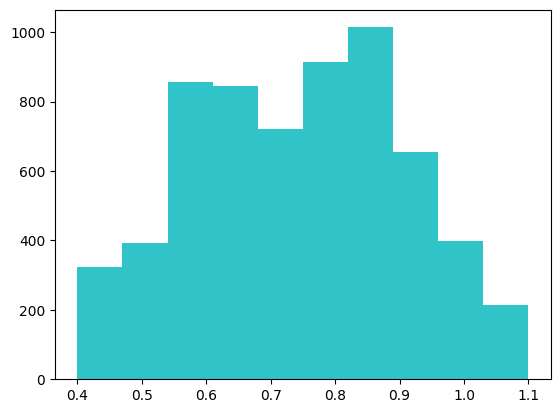

In [63]:
max_value_8_s = max_value(conditions_s[5],data_s)

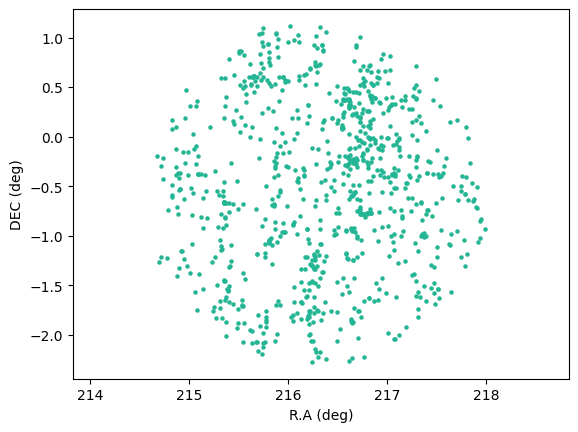

In [64]:
rosette(conditions_s[5],data_s,max_value_8_s[0],max_value_8_s[2])

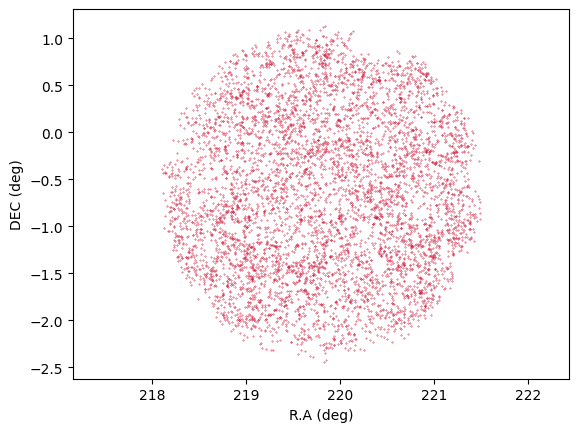

In [65]:
rosette_all(conditions_s[6],data_s)

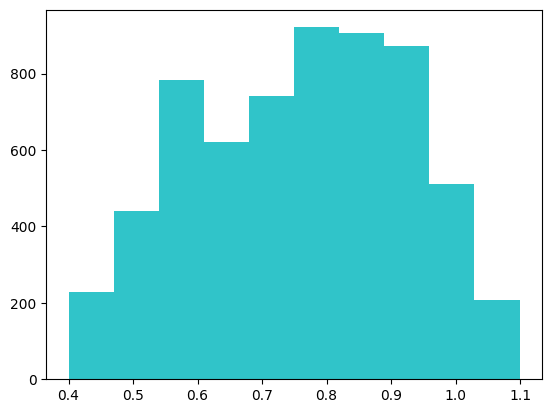

In [66]:
max_value_9_s = max_value(conditions_s[6],data_s)

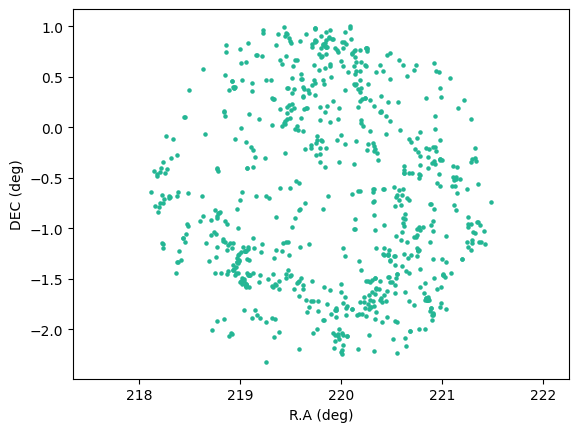

In [67]:
rosette(conditions_s[6],data_s,max_value_9_s[0],max_value_9_s[2])

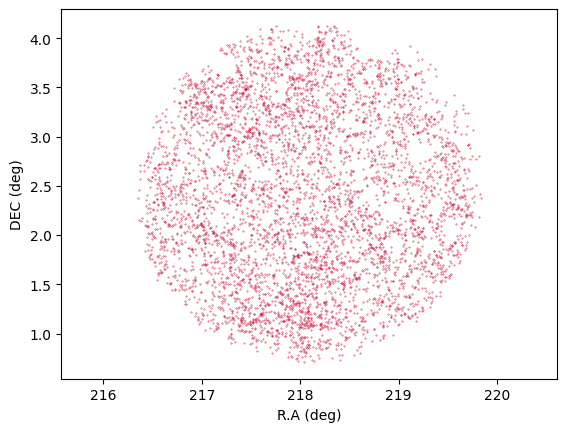

In [68]:
rosette_all(conditions_s[7],data_s)

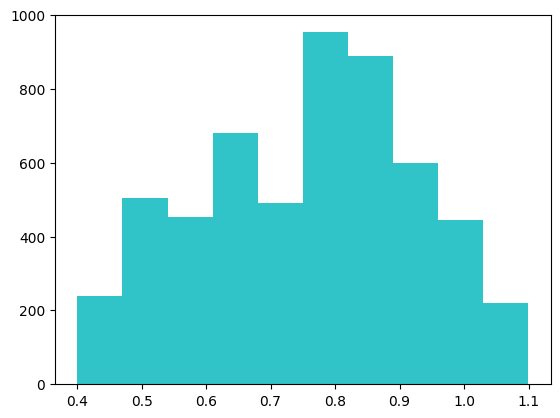

In [69]:
max_value_10_s = max_value(conditions_s[7],data_s)

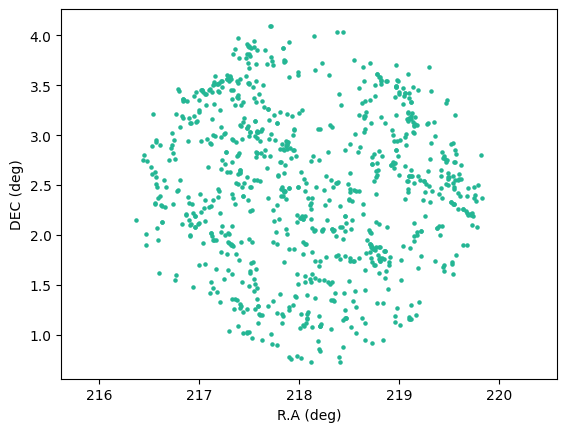

In [70]:
rosette(conditions_s[7],data_s,max_value_10_s[0],max_value_10_s[2])

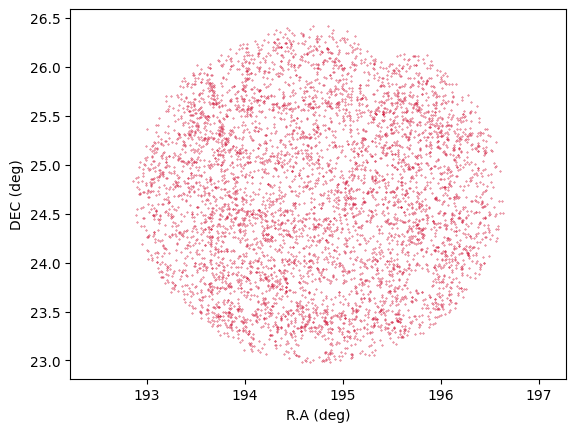

In [71]:
rosette_all(conditions_s[8],data_s)

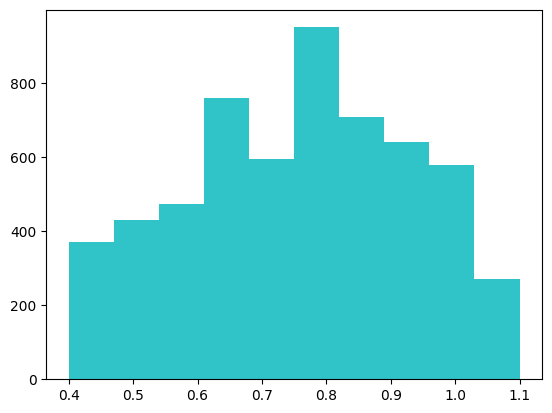

In [72]:
max_value_16_s = max_value(conditions_s[8],data_s)

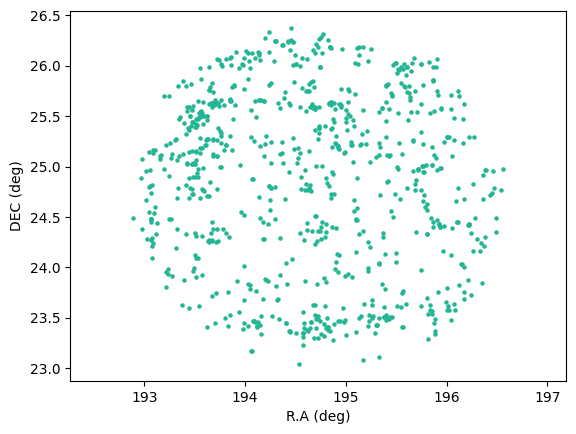

In [73]:
rosette(conditions_s[8],data_s,max_value_16_s[0],max_value_16_s[2])

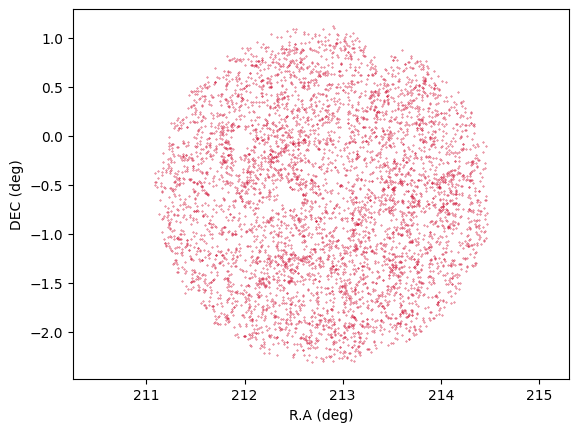

In [74]:
rosette_all(conditions_s[9],data_s)

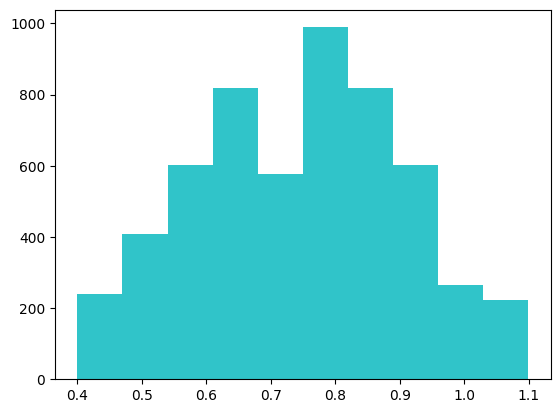

In [75]:
max_value_17_s = max_value(conditions_s[9],data_s)

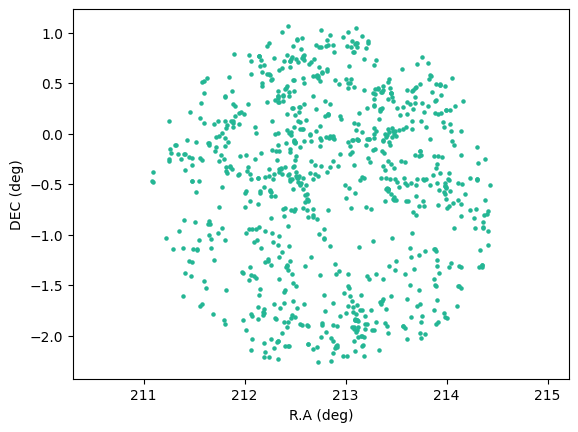

In [76]:
rosette(conditions_s[9],data_s,max_value_17_s[0],max_value_17_s[2])